# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [ ]:
# Import essential libraries for data manipulation and analysis

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from itertools import combinations

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [ ]:
# Importing the file porter_data_1.csv

import os
from google.colab import drive
drive.mount('/content/drive')

# Select the folder having data files
root_file_path = '/content/drive/MyDrive/ML & AI/Course 2 - Machine Learning/Linear Regression Assignment/Delivery_Starter/porter_data_1.csv'

porter_df = pd.read_csv(root_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
porter_df.head(5)

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

In [ ]:
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

In [ ]:
porter_df.shape

(175777, 14)

In [ ]:
#Missing values in columns
porter_df.isnull().sum()

market_id                   0
created_at                  0
actual_delivery_time        0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_dashers       0
total_busy_dashers          0
total_outstanding_orders    0
distance                    0
dtype: int64

In [ ]:
#Find the columns with negative values

print(porter_df.select_dtypes(include=[np.number]).columns[(porter_df.select_dtypes(include=[np.number]) < 0).any()].tolist())

['min_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']


In [ ]:
# Find the count of negative values in each column
for col in porter_df.columns:
    if porter_df[col].dtype in [np.number]:
        neg_count = (porter_df[col] < 0).sum()
        print(f"Column '{col}': {neg_count} zero values")

Column 'market_id': 0 zero values
Column 'order_protocol': 0 zero values
Column 'total_onshift_dashers': 21 zero values
Column 'total_busy_dashers': 21 zero values
Column 'total_outstanding_orders': 41 zero values
Column 'distance': 0 zero values


In [ ]:
# checking negative values in min_item_price
porter_df[porter_df.min_item_price < 0 ]

market_id           created_at actual_delivery_time  \
711           1.0  2015-01-29 02:59:28  2015-01-29 03:53:28   
1242          2.0  2015-02-06 05:26:55  2015-02-06 06:11:55   
41256         2.0  2015-02-08 23:20:59  2015-02-08 23:55:59   
41264         2.0  2015-02-08 06:02:12  2015-02-08 06:38:12   
68513         5.0  2015-02-14 22:01:48  2015-02-14 22:43:48   
81136         3.0  2015-02-15 20:46:57  2015-02-15 21:30:57   
92702         3.0  2015-01-25 19:18:20  2015-01-25 20:10:20   
106915        1.0  2015-01-24 03:45:37  2015-01-24 04:38:37   
106983        1.0  2015-02-10 03:31:22  2015-02-10 04:08:22   
147683        2.0  2015-02-02 20:24:15  2015-02-02 20:56:15   
151780        5.0  2015-02-02 20:22:39  2015-02-02 21:01:39   
166561        2.0  2015-02-04 16:56:44  2015-02-04 17:37:44   

        store_primary_category  order_protocol  total_items  subtotal  \
711                         28             4.0            3      1003   
1242                        28             4.0           35      1786   
41256                       28             4.0           25      1636   
41264                       28             4.0           15      1822   
68513                       55             3.0            1      3099   
81136                        4             4.0           16      1601   
92702                       10             3.0            7      6095   
106915                      28             4.0           10      1938   
106983                      38             5.0            5      2585   
147683                      28             4.0           18      1646   
151780                      28             4.0            3       951   
166561                      28             4.0           16      2162   

        num_distinct_items  min_item_price  max_item_price  \
711                      3             -86            1066   
1242                     4              -1             488   
41256                    5             -35             514   
41264                    4             -48             433   
68513                    1             -31              52   
81136                    5             -13             194   
92702                    7             -30            1211   
106915                   8              -9             594   
106983                   3              -7            1235   
147683                   3              -6             297   
151780                   2             -51             804   
166561                   5             -52             397   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
711                      24.0                29.0                      38.0   
1242                     33.0                36.0                      52.0   
41256                    81.0                61.0                      72.0   
41264                    36.0                36.0                      43.0   
68513                    22.0                26.0                      34.0   
81136                    29.0                17.0                      22.0   
92702                    18.0                23.0                      12.0   
106915                   28.0                40.0                      46.0   
106983                   49.0                47.0                      59.0   
147683                   49.0                41.0                      37.0   
151780                   21.0                16.0                      39.0   
166561                   15.0                13.0                      15.0   

        distance  
711        28.84  
1242       23.48  
41256      18.76  
41264      13.56  
68513      15.08  
81136      35.00  
92702      35.12  
106915     22.04  
106983     13.32  
147683     25.52  
151780      9.76  
166561     22.36

In [ ]:
# Drop  rows with negative values

num_cols = porter_df.select_dtypes(include=[np.number]).columns
porter_df = porter_df[(porter_df[num_cols] >= 0).all(axis=1)]
print(porter_df.shape)


# Find the count of negative values in each column
for col in porter_df.columns:
    if porter_df[col].dtype in [np.number]:
        neg_count = (porter_df[col] < 0).sum()
        print(f"Column '{col}': {neg_count} zero values")

(175687, 14)
Column 'market_id': 0 zero values
Column 'order_protocol': 0 zero values
Column 'total_onshift_dashers': 0 zero values
Column 'total_busy_dashers': 0 zero values
Column 'total_outstanding_orders': 0 zero values
Column 'distance': 0 zero values


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [ ]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

porter_df.created_at = pd.to_datetime(porter_df.created_at)
porter_df.actual_delivery_time = pd.to_datetime(porter_df.actual_delivery_time)
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175687 non-null  float64       
 1   created_at                175687 non-null  datetime64[ns]
 2   actual_delivery_time      175687 non-null  datetime64[ns]
 3   store_primary_category    175687 non-null  int64         
 4   order_protocol            175687 non-null  float64       
 5   total_items               175687 non-null  int64         
 6   subtotal                  175687 non-null  int64         
 7   num_distinct_items        175687 non-null  int64         
 8   min_item_price            175687 non-null  int64         
 9   max_item_price            175687 non-null  int64         
 10  total_onshift_dashers     175687 non-null  float64       
 11  total_busy_dashers        175687 non-null  float64       
 12  total_o

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [ ]:
# Convert categorical features to category type

porter_df.market_id = porter_df.market_id.astype('category')
porter_df.order_protocol = porter_df.order_protocol.astype('category')
porter_df.store_primary_category = porter_df.store_primary_category.astype('category')
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175687 non-null  category      
 1   created_at                175687 non-null  datetime64[ns]
 2   actual_delivery_time      175687 non-null  datetime64[ns]
 3   store_primary_category    175687 non-null  category      
 4   order_protocol            175687 non-null  category      
 5   total_items               175687 non-null  int64         
 6   subtotal                  175687 non-null  int64         
 7   num_distinct_items        175687 non-null  int64         
 8   min_item_price            175687 non-null  int64         
 9   max_item_price            175687 non-null  int64         
 10  total_onshift_dashers     175687 non-null  float64       
 11  total_busy_dashers        175687 non-null  float64       
 12  total_o

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [ ]:
# Calculate time taken in minutes

porter_df['time_taken_mins'] = (porter_df.actual_delivery_time - porter_df.created_at).dt.total_seconds() / 60
porter_df.head()

market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  time_taken_mins  
0                      21.0     34.44             47.0  
1                       2.0     27.60             44.0  
2                      18.0     11.56             55.0  
3                       8.0     31.80             59.0  
4                       7.0      8.20             46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [ ]:
# Extract the hour and day of week from the 'created_at' timestamp

porter_df['order_hour'] = porter_df.created_at.dt.hour
porter_df['order_day'] = porter_df.created_at.dt.dayofweek

# Create a categorical feature 'isWeekend'

porter_df['isWeekend'] = np.where(porter_df.order_day.isin(['Saturday', 'Sunday']), 1, 0)
porter_df.head()

market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  time_taken_mins  order_hour  order_day  \
0                      21.0     34.44             47.0          22          4   
1                       2.0     27.60             44.0          21          1   
2                      18.0     11.56             55.0           0          0   
3                       8.0     31.80             59.0           3          3   
4                       7.0      8.20             46.0           2          1   

   isWeekend  
0          0  
1          0  
2          0  
3          0  
4          0

In [ ]:
# Drop unnecessary columns

# We can drop created_at and actual_delivery_time as we have created new columns for analysis and these original columns won't be used anymore

porter_df.drop(['created_at', 'actual_delivery_time'], axis = 1, inplace = True)
porter_df.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  time_taken_mins  \
0                14.0                      21.0     34.44             47.0   
1                 2.0                       2.0     27.60             44.0   
2                 6.0                      18.0     11.56             55.0   
3                 6.0                       8.0     31.80             59.0   
4                 5.0                       7.0      8.20             46.0   

   order_hour  order_day  isWeekend  
0          22          4          0  
1          21          1          0  
2           0          0          0  
3           3          3          0  
4           2          1          0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [ ]:
# Define target variable (y) and features (X)

target = 'time_taken_mins'
features = [col for col in porter_df.columns if col != target]

X = porter_df[features]
y = porter_df[target]

In [ ]:
X.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'order_hour', 'order_day',
       'isWeekend'],
      dtype='object')

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [ ]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140549, 15), (35138, 15), (140549,), (35138,))

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [ ]:
porter_df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken_mins', 'order_hour',
       'order_day', 'isWeekend'],
      dtype='object')

In [ ]:
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 175687 non-null  category
 1   store_primary_category    175687 non-null  category
 2   order_protocol            175687 non-null  category
 3   total_items               175687 non-null  int64   
 4   subtotal                  175687 non-null  int64   
 5   num_distinct_items        175687 non-null  int64   
 6   min_item_price            175687 non-null  int64   
 7   max_item_price            175687 non-null  int64   
 8   total_onshift_dashers     175687 non-null  float64 
 9   total_busy_dashers        175687 non-null  float64 
 10  total_outstanding_orders  175687 non-null  float64 
 11  distance                  175687 non-null  float64 
 12  time_taken_mins           175687 non-null  float64 
 13  order_hour                175687 n

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation

categorical_cols = ['market_id', 'store_primary_category', 'order_protocol', 'order_hour', 'order_day', 'isWeekend']

numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

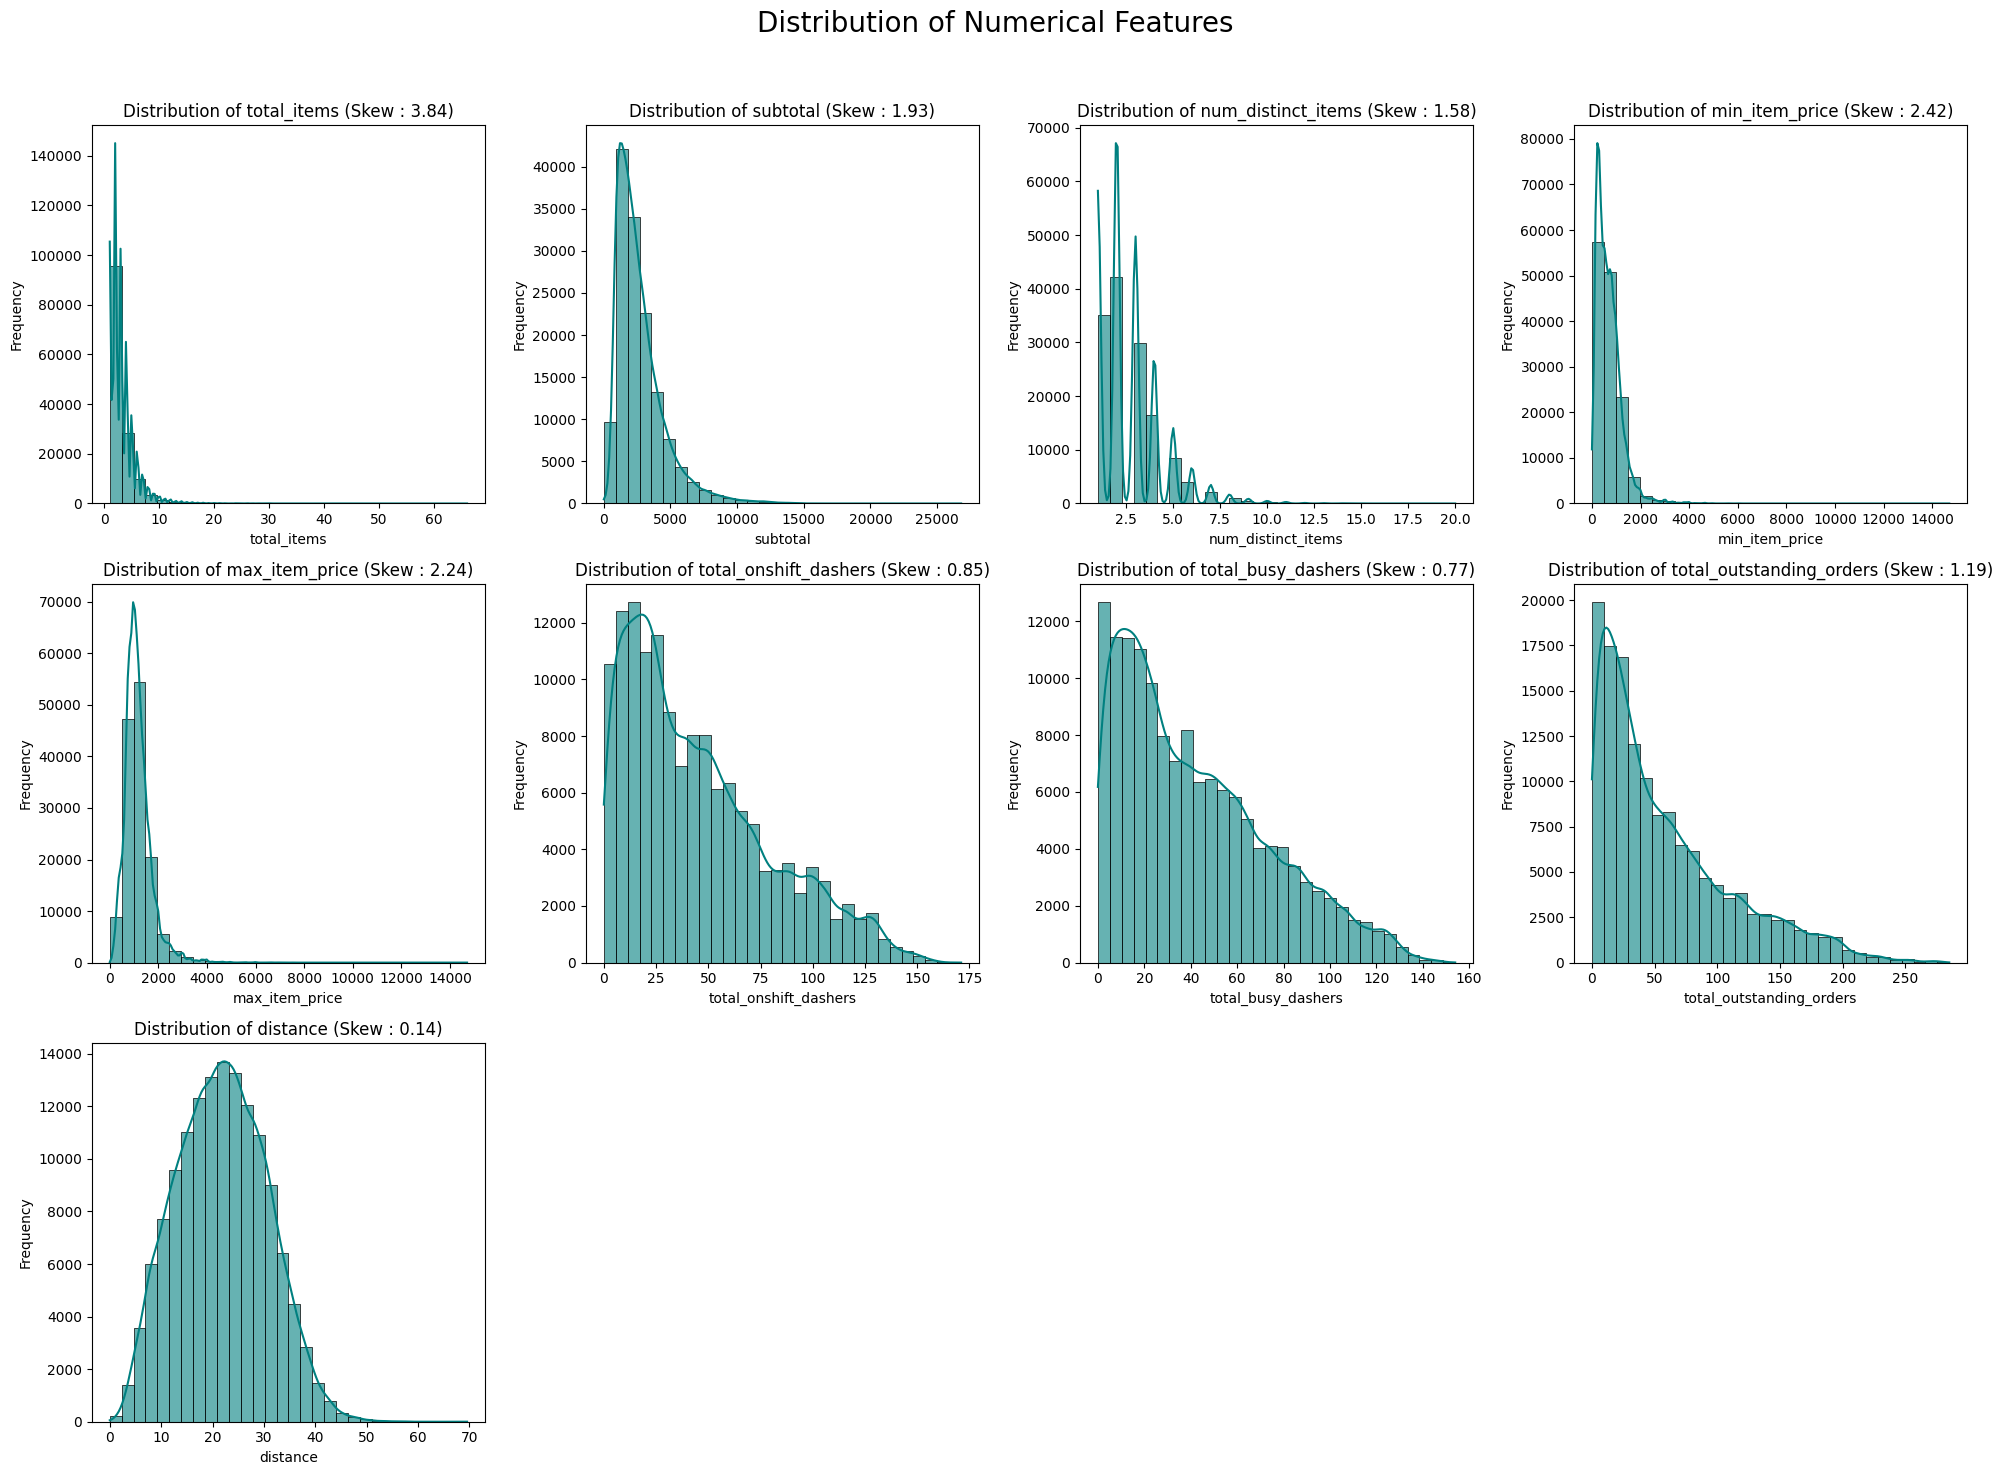

In [ ]:
# Plot distributions for all numerical columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3,4, i)
    sns.histplot(X_train[col], kde=True, bins=30, color='teal', alpha=0.6,edgecolor='black', linewidth=0.5)
    plt.title(f'Distribution of {col} (Skew : {X_train[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Distribution of Numerical Features\n\n', fontsize=20)
plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

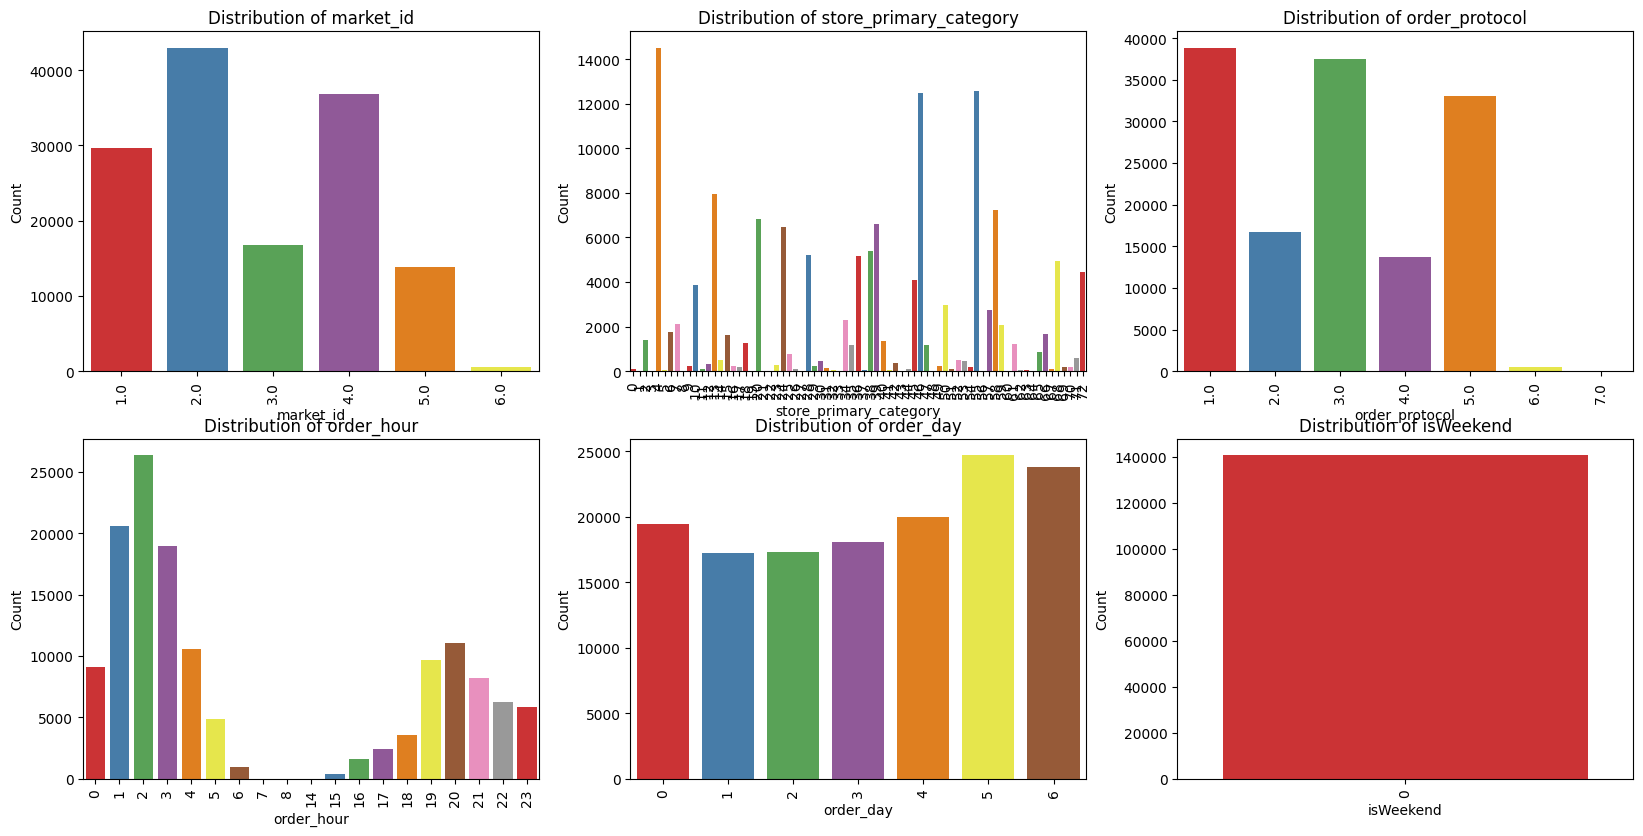

In [ ]:
# Distribution of categorical columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3,3, i)
    sns.countplot(data=X_train, x=col, palette='Set1')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

<Axes: xlabel='time_taken_mins', ylabel='Count'>

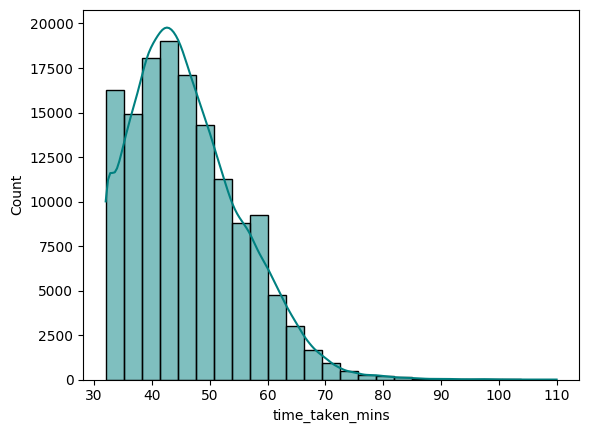

In [ ]:
# Distribution of time_taken

sns.histplot(y_train, bins=25, kde=True,color = 'teal')

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

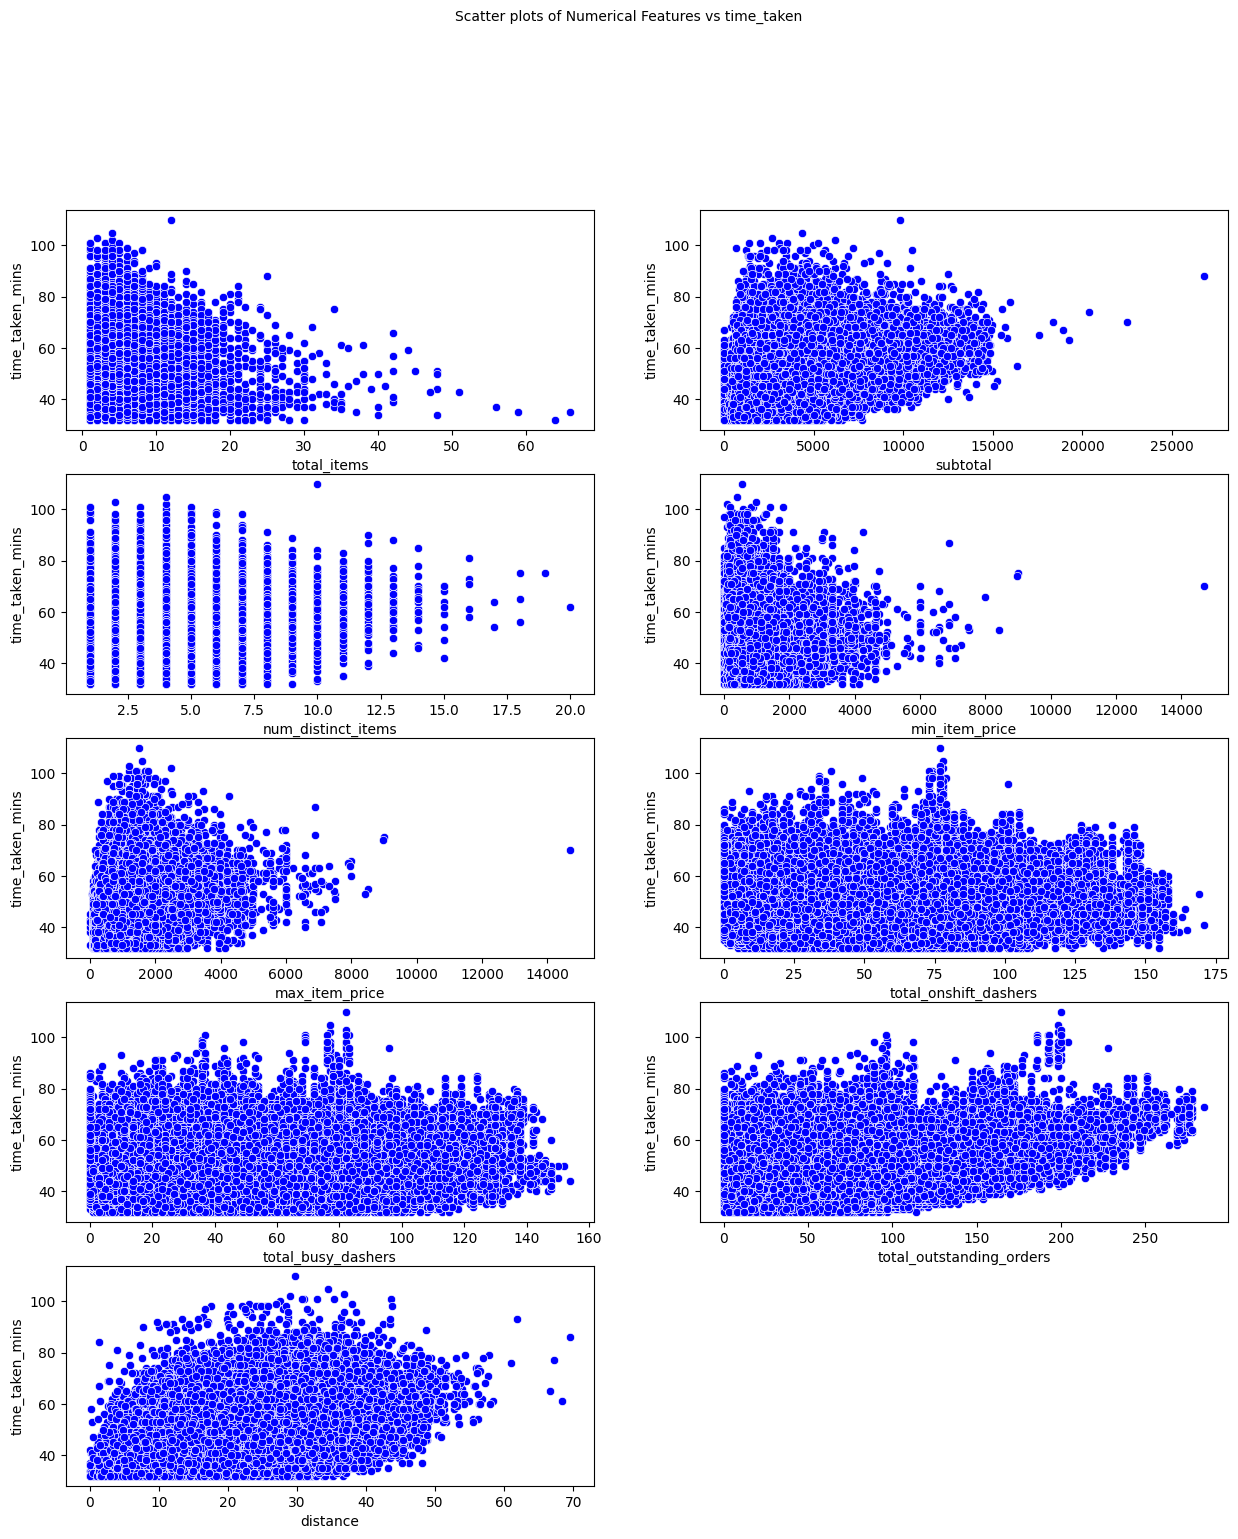

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(15, 20))
plt.suptitle('Scatter plots of Numerical Features vs time_taken', fontsize=10)
i = 1
for var in numerical_cols:
    plt.subplot(6,2,i)
    sns.scatterplot(x=X_train[var], y=y_train, color = 'blue')
    i += 1
plt.show()

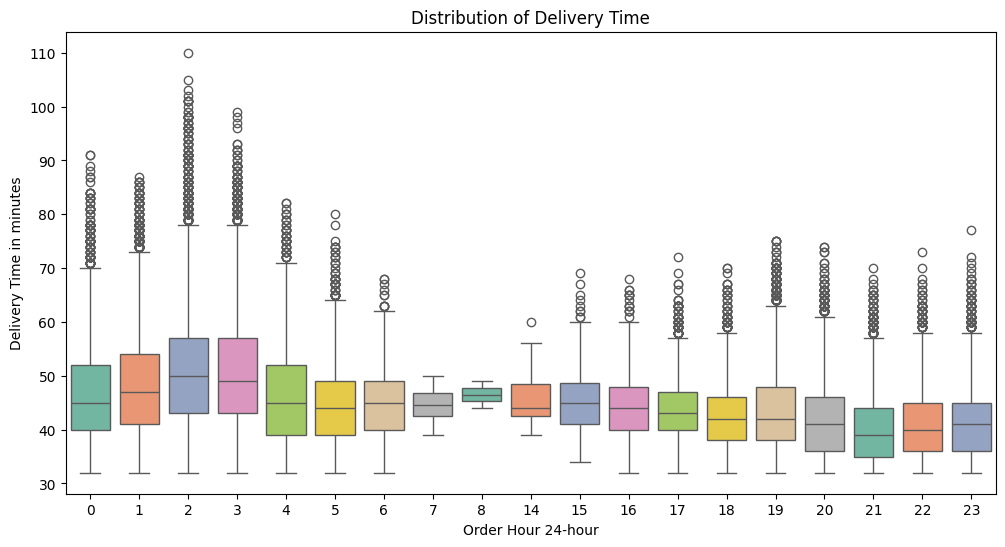

In [ ]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(12, 6))

# Create a boxplot to show the time_taken for different hours
sns.boxplot(x=X_train['order_hour'], y=y_train, palette="Set2")

# Set labels and title
plt.xlabel("Order Hour 24-hour")
plt.ylabel("Delivery Time in minutes")
plt.title("Distribution of Delivery Time")

plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

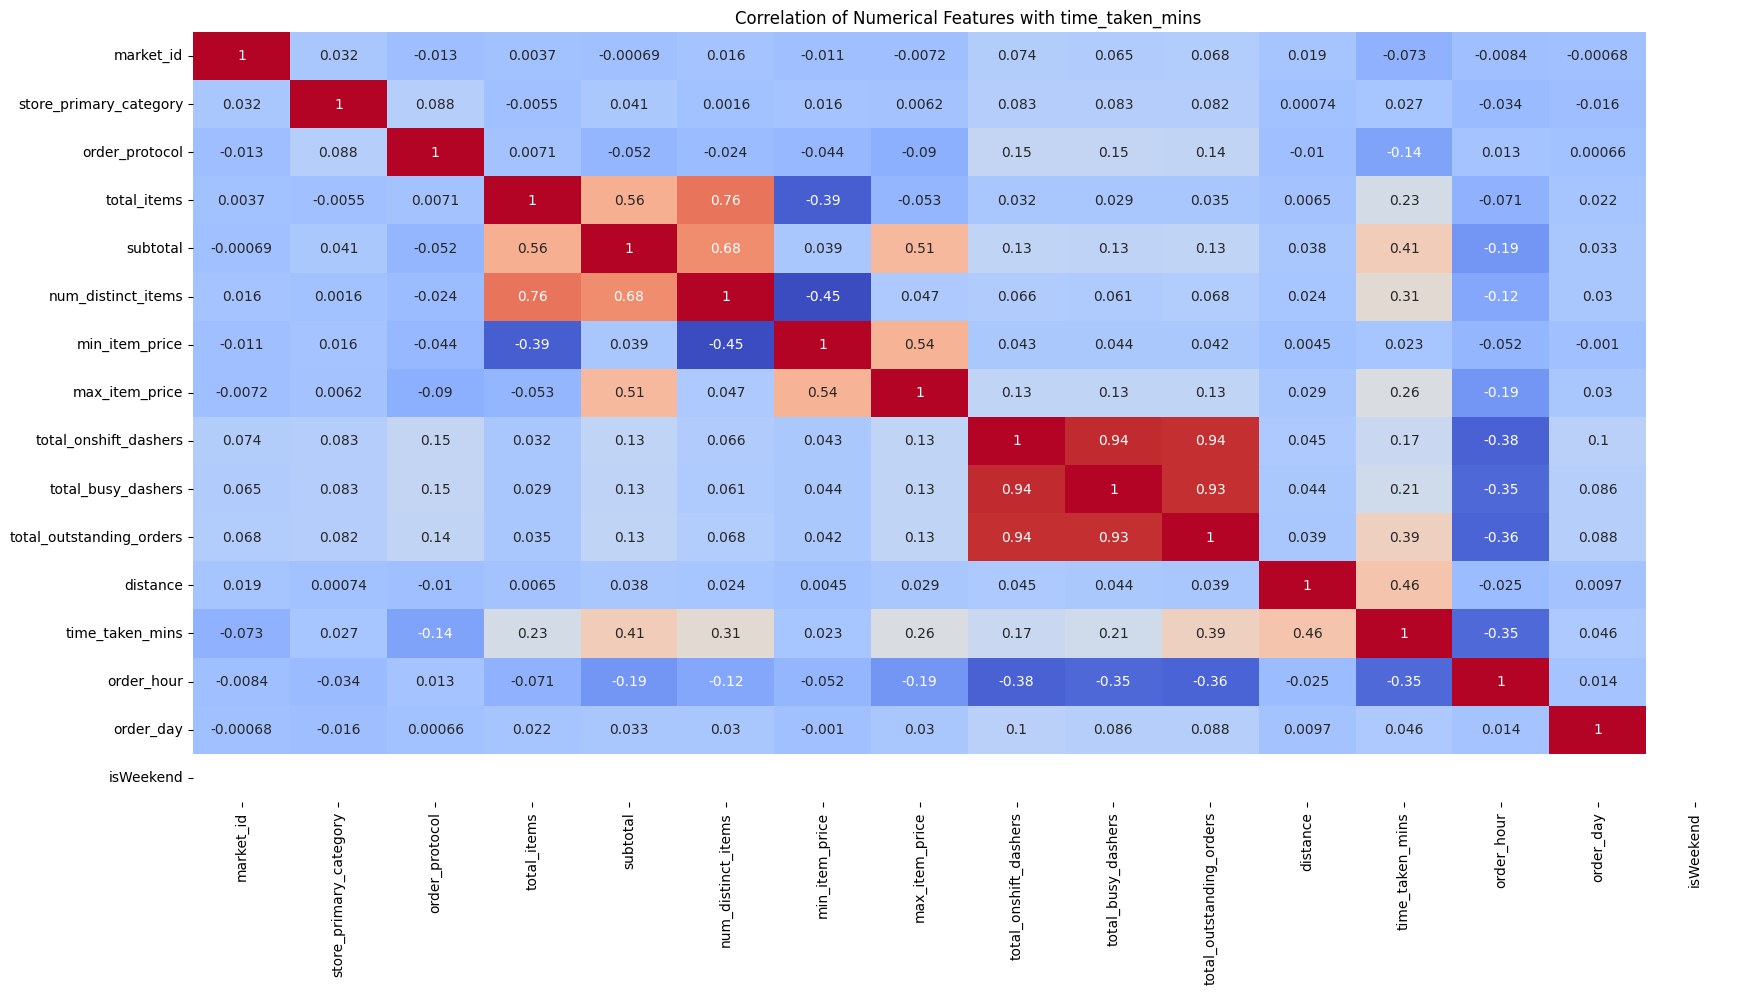

In [ ]:
# Plot the heatmap of the correlation matrix

plt.figure(figsize=(20,10))
sns.heatmap( porter_df.corr(),  annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation of Numerical Features with time_taken_mins')
plt.show()



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [ ]:
corr_matrix = X_train[numerical_cols].corrwith(y_train).sort_values(ascending=False)
corr_matrix.head(10)

distance                    0.459855
subtotal                    0.412419
total_outstanding_orders    0.385697
num_distinct_items          0.311607
max_item_price              0.255626
total_items                 0.242620
total_busy_dashers          0.206174
total_onshift_dashers       0.170317
min_item_price              0.024207
dtype: float64

In [ ]:
# Drop 3-5 weakly correlated columns from training dataset

weakly_corr_columns = ['min_item_price', 'total_onshift_dashers','total_busy_dashers']
X_train.drop(weakly_corr_columns, axis=1, inplace=True)
X_test.drop(weakly_corr_columns, axis=1, inplace=True)


In [ ]:
#Updating numerical_cols after dropping weakly_corr_columns

numerical_cols = [col for col in numerical_cols if col not in weakly_corr_columns]
numerical_cols


['total_items',
 'subtotal',
 'num_distinct_items',
 'max_item_price',
 'total_outstanding_orders',
 'distance']

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

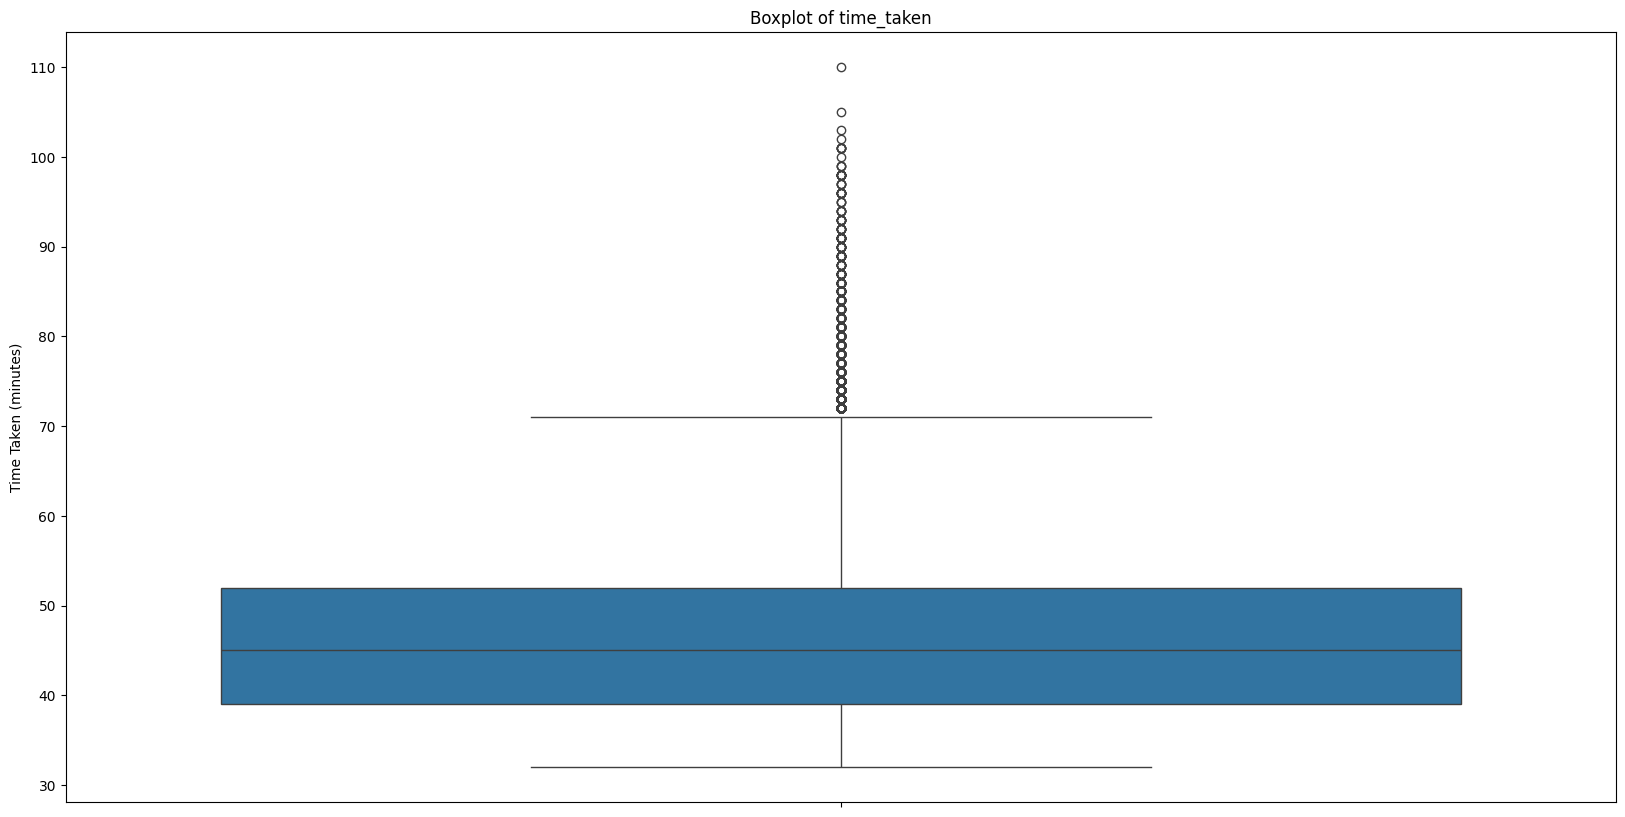

In [ ]:
# Boxplot for time_taken

plt.figure(figsize=(20, 10))
sns.boxplot(y=y_train)
plt.title('Boxplot of time_taken')
plt.ylabel('Time Taken (minutes)')
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [ ]:
# Handle outliers

def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in numerical_cols:
    X_train = remove_outliers(X_train, col)
    X_test = remove_outliers(X_test, col)
    print(f"Removed outliers from {col}")

Removed outliers from total_items
Removed outliers from subtotal
Removed outliers from num_distinct_items
Removed outliers from max_item_price
Removed outliers from total_outstanding_orders
Removed outliers from distance


In [ ]:
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

KeyError: "None of [Index([110142,  79473, 122833,  69608, 100630, 118518,  26761,  39800,  11291,\n       102810,\n       ...\n        36881, 132837, 174899,  91276, 147991,  48754,  90710, 158013,  93032,\n       106542],\n      dtype='int64', length=30138)] are in the [index]"

In [ ]:
print(X_train.shape)
print(y_train.shape)

(120332, 12)
(120332,)


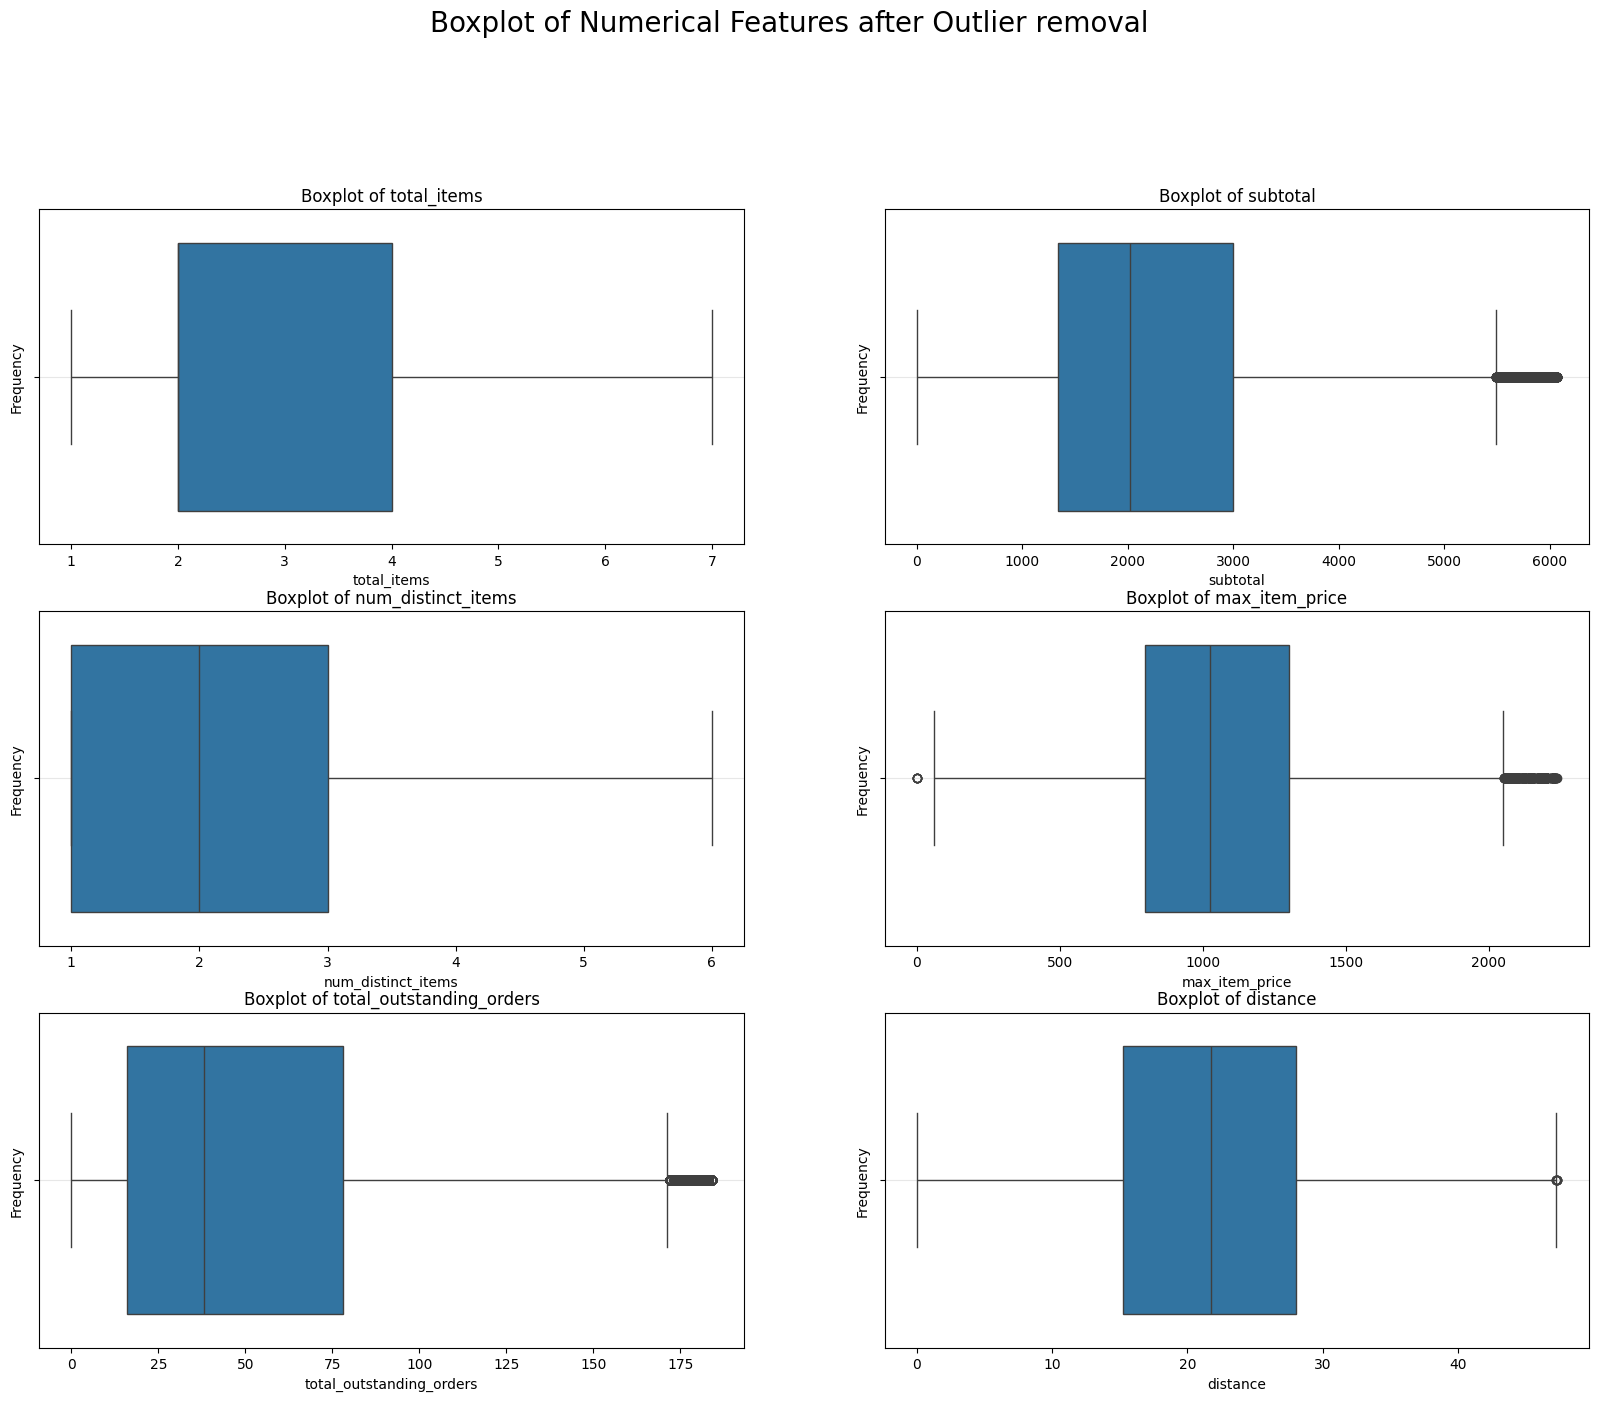

In [ ]:
plt.figure(figsize=(20, 20))
plt.suptitle('Boxplot of Numerical Features after Outlier removal', fontsize=20)
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=X_train[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.3)

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Numerical columns
print("Numerical columns ",numerical_cols)
# Categorical columns
print("Catetorical cols",categorical_cols)

Numerical columns  ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'distance']
Catetorical cols ['market_id', 'store_primary_category', 'order_protocol', 'order_hour', 'order_day', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

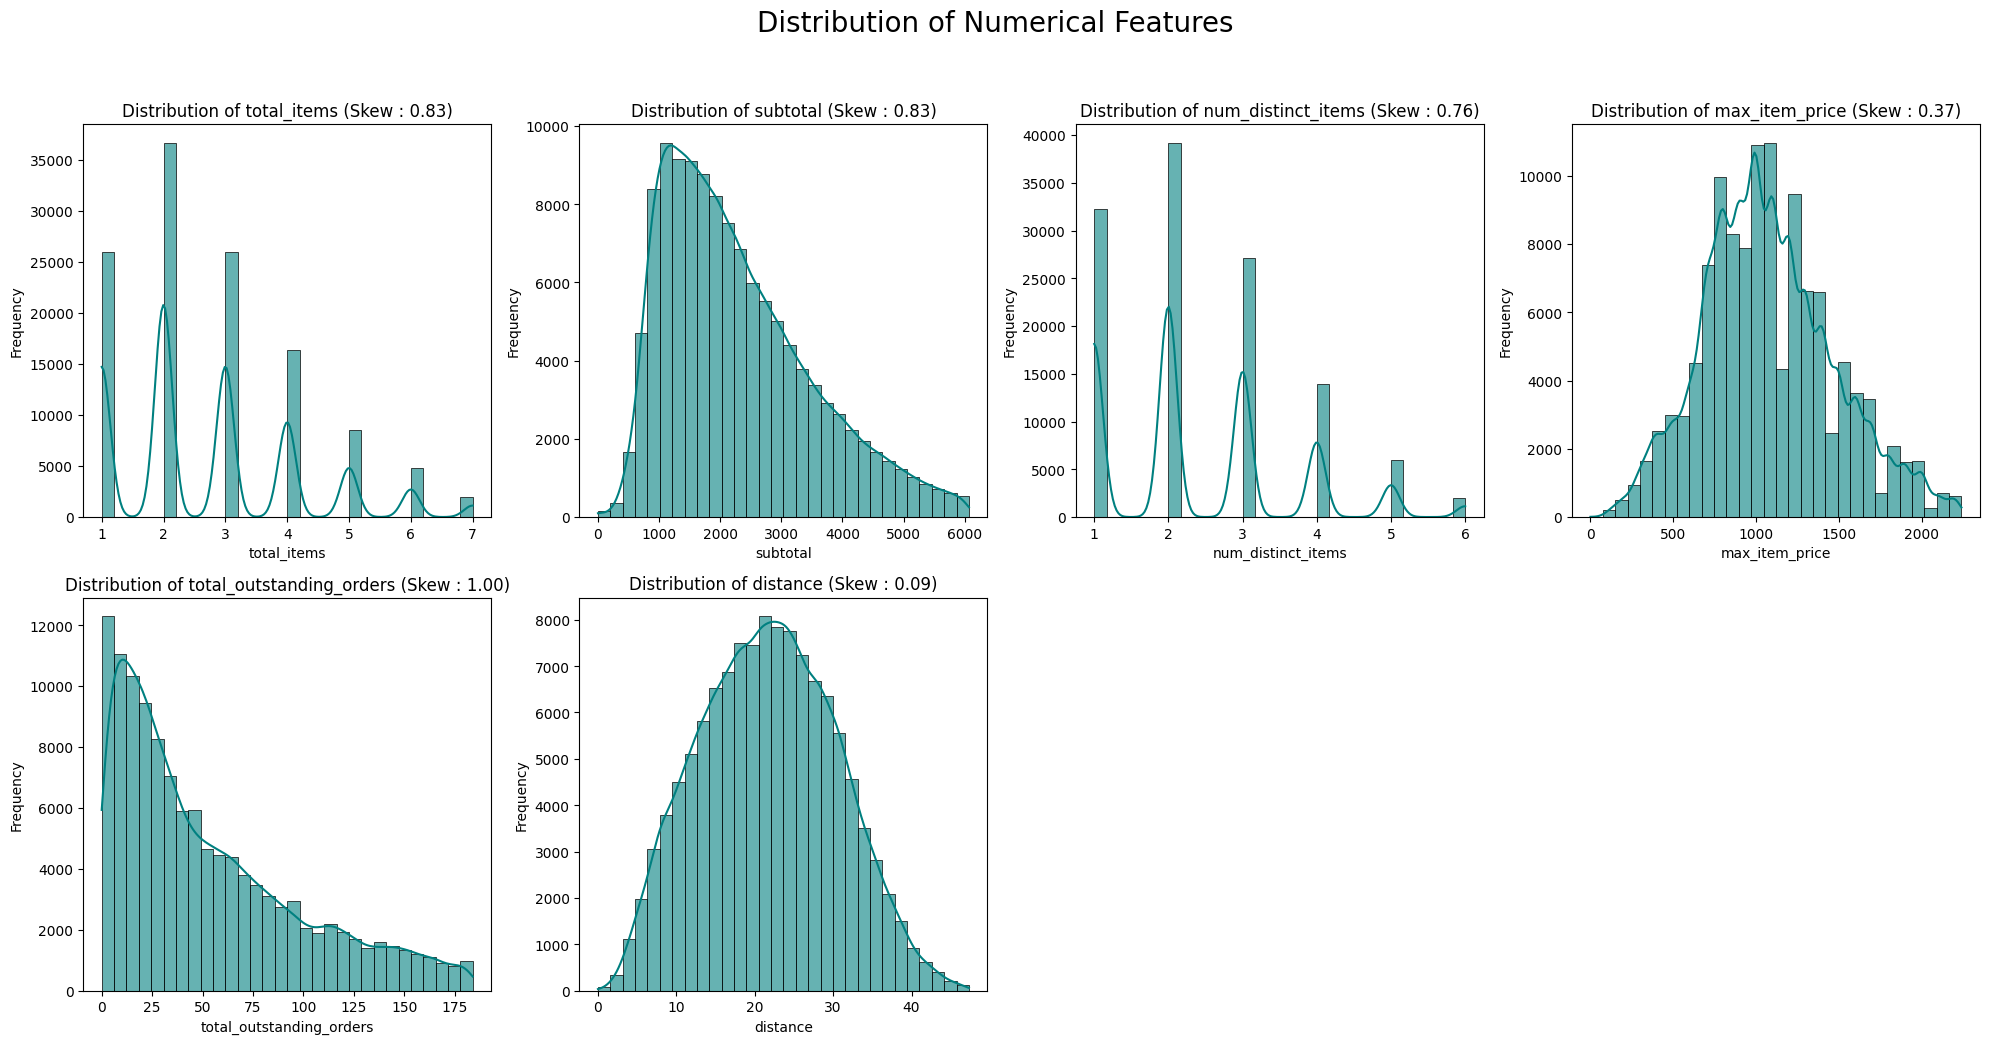

In [ ]:
# Plot distributions for all numerical columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3,4, i)
    sns.histplot(X_train[col], kde=True, bins=30, color='teal', alpha=0.6,edgecolor='black', linewidth=0.5)
    plt.title(f'Distribution of {col} (Skew : {X_train[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Distribution of Numerical Features\n\n', fontsize=20)
plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

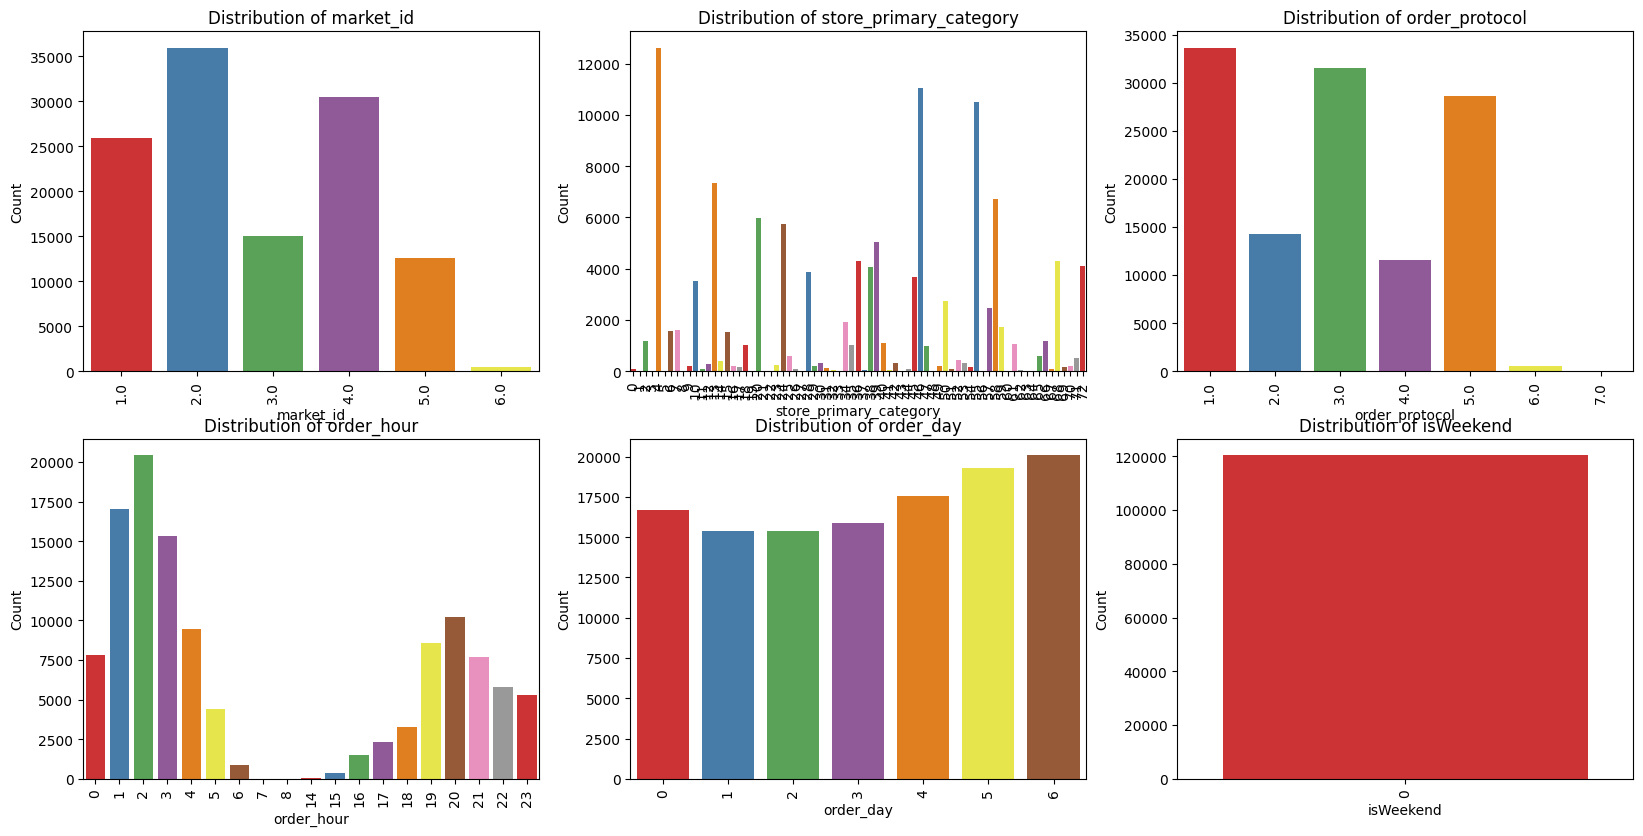

In [ ]:
# Distribution of categorical columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3,3, i)
    sns.countplot(data=X_train, x=col, palette='Set1')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

<Axes: xlabel='time_taken_mins', ylabel='Count'>

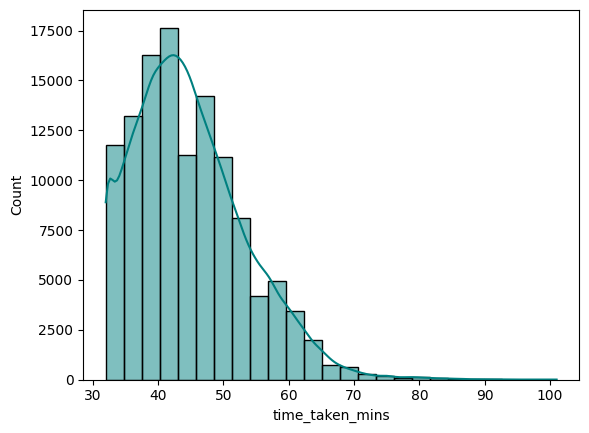

In [ ]:
# Distribution of time_taken

sns.histplot(y_train, bins=25, kde=True,color = 'teal')

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

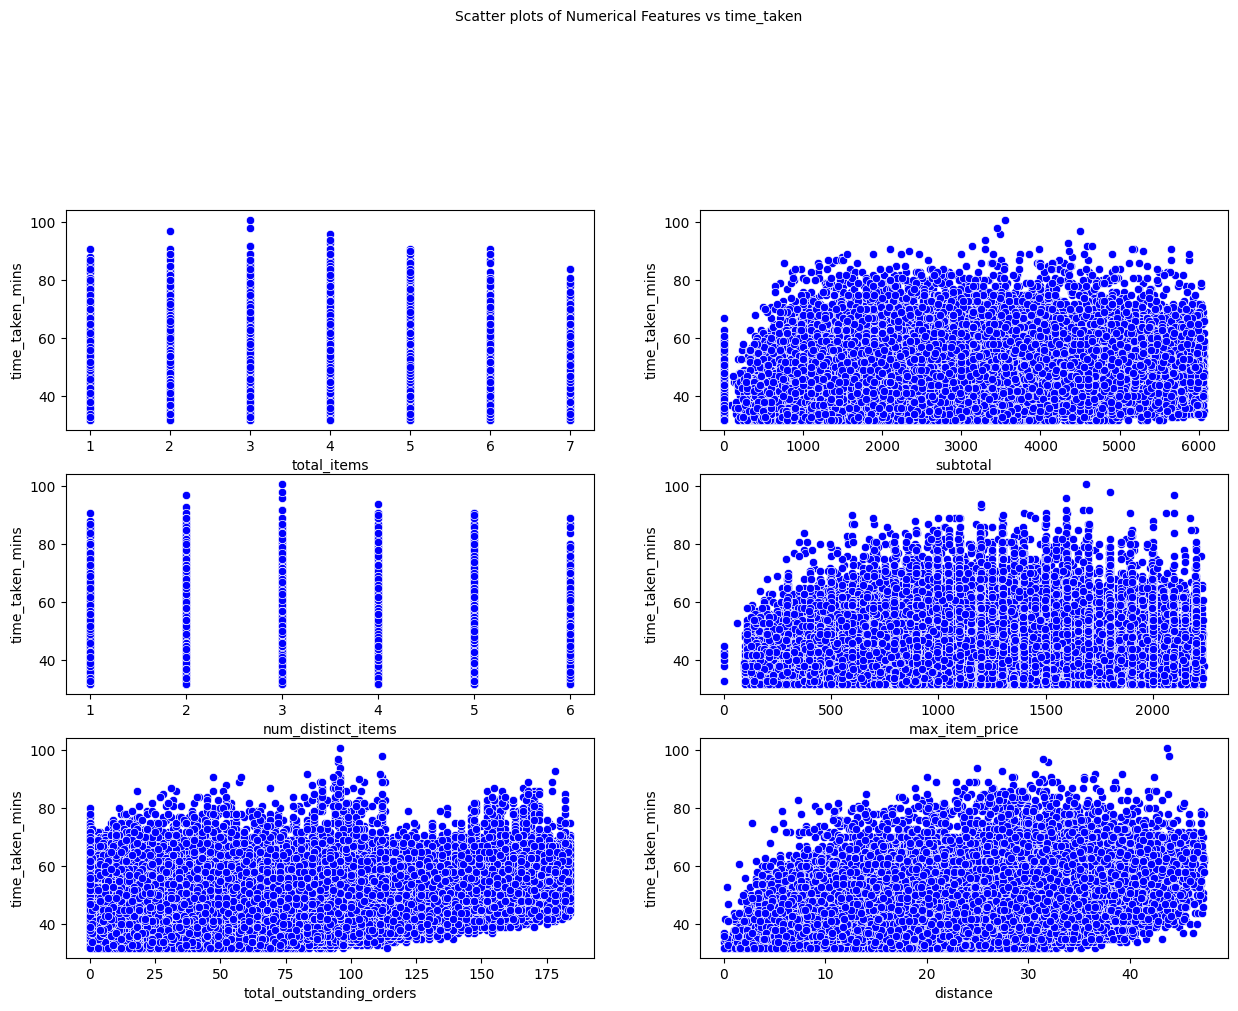

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(15, 20))
plt.suptitle('Scatter plots of Numerical Features vs time_taken', fontsize=10)
i = 1
for var in numerical_cols:
    plt.subplot(6,2,i)
    sns.scatterplot(x=X_train[var], y=y_train, color = 'blue')
    i += 1
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset

#We have already dropped the weakly_correlated_cols from training dataset above.

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries

from sklearn.preprocessing import StandardScaler

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [ ]:
X_train = pd.get_dummies(X_train, columns=['market_id','order_protocol','order_day'], drop_first=True,dtype='int')
X_test = pd.get_dummies(X_test, columns=['market_id','order_protocol','order_day'], drop_first=True,dtype='int')

In [ ]:
X_train.columns

Index(['store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'max_item_price', 'total_outstanding_orders',
       'distance', 'order_hour', 'isWeekend', 'market_id_2.0', 'market_id_3.0',
       'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'order_protocol_2.0',
       'order_protocol_3.0', 'order_protocol_4.0', 'order_protocol_5.0',
       'order_protocol_6.0', 'order_protocol_7.0', 'order_day_1',
       'order_day_2', 'order_day_3', 'order_day_4', 'order_day_5',
       'order_day_6'],
      dtype='object')

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

In [ ]:
X_train.head(5)

store_primary_category  total_items  subtotal  num_distinct_items  \
110609                     46     2.241890  0.573932            0.486454   
171156                     55    -0.497105  1.416250           -0.328936   
141352                     46    -1.181853 -1.313422           -1.144325   
37170                      55    -1.181853 -1.152074           -1.144325   
80311                      36     1.557141  0.412585            1.301844   

        max_item_price  total_outstanding_orders  distance  order_hour  \
110609       -1.210525                  0.760260  0.159285           2   
171156       -0.187499                 -0.364551  0.375962           1   
141352       -0.947172                  1.179307 -0.785793           1   
37170        -0.957301                  0.076551  1.574598           0   
80311        -0.704076                 -0.276331  0.380572           1   

        isWeekend  market_id_2.0  ...  order_protocol_4.0  order_protocol_5.0  \
110609          0              0  ...                   0                   0   
171156          0              0  ...                   0                   0   
141352          0              1  ...                   0                   1   
37170           0              0  ...                   0                   0   
80311           0              1  ...                   0                   0   

        order_protocol_6.0  order_protocol_7.0  order_day_1  order_day_2  \
110609                   0                   0            0            0   
171156                   0                   0            0            0   
141352                   0                   0            0            0   
37170                    0                   0            0            0   
80311                    0                   0            0            0   

        order_day_3  order_day_4  order_day_5  order_day_6  
110609            0            0            0            0  
171156            0            1            0            0  
141352            0            0            1            0  
37170             0            0            0            1  
80311             0            1            0            0  

[5 rows x 26 columns]

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [ ]:
# Create/Initialise the model

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [ ]:
print(y_train.shape)
print(X_train.shape)

(120332,)
(120332, 26)


In [ ]:
# Train the model using the training data

model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        time_taken_mins   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     7088.
Date:                Sat, 24 May 2025   Prob (F-statistic):               0.00
Time:                        16:19:18   Log-Likelihood:            -3.7455e+05
No. Observations:              120332   AIC:                         7.491e+05
Df Residuals:                  120306   BIC:                         7.494e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
# Make predictions

y_train_pred = model.predict(X_train_sm)
y_test_pred = model.predict(X_test_sm)

In [ ]:
# Find results for evaluation metrics

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Print results
print("Test data :")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

# Print results
print("Training data :")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Test data :
Mean Absolute Error (MAE): 4.20
Mean Squared Error (MSE): 28.93
Root Mean Squared Error (RMSE): 5.38
R² Score: 0.5897
Training data :
Mean Absolute Error (MAE): 4.22
Mean Squared Error (MSE): 29.59
Root Mean Squared Error (RMSE): 5.44
R² Score: 0.5956


In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data

feature        VIF
0                      const  16.593609
2                total_items   6.230140
4         num_distinct_items   4.842980
3                   subtotal   3.958429
5             max_item_price   2.385469
10             market_id_2.0   2.070714
12             market_id_4.0   2.035402
26               order_day_6   1.840391
25               order_day_5   1.815026
24               order_day_4   1.755067
6   total_outstanding_orders   1.731379
23               order_day_3   1.696930
22               order_day_2   1.681381
21               order_day_1   1.681105
16        order_protocol_3.0   1.572777
18        order_protocol_5.0   1.539111
11             market_id_3.0   1.399496
13             market_id_5.0   1.351647
17        order_protocol_4.0   1.350819
15        order_protocol_2.0   1.322852
8                 order_hour   1.270521
1     store_primary_category   1.064147
19        order_protocol_6.0   1.019673
14             market_id_6.0   1.015462
7                   distance   1.009838
20        order_protocol_7.0   1.001752
9                  isWeekend        NaN

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [ ]:
# Drop the constant column

X_train_sm= X_train_sm.drop(columns=['const'],axis=1)
X_test_sm= X_test_sm.drop(columns=['const'],axis=1)

# Loop through the number of features and test the model

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=8, step=1) # Recursive Feature Elimination
selector = selector.fit(X_train_sm, y_train) # Fit the model
# Get the ranking of features
ranking = selector.ranking_ # Get the ranking of features
selected_features = X_train_sm.columns[selector.support_].tolist() # Get the selected features
print(f"Selected features: {selected_features}") # Print the selected features

Selected features: ['total_outstanding_orders', 'distance', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'order_protocol_5.0']


In [ ]:
# Build the final model with selected number of features

X_train_sm = X_train_sm[selected_features]
X_test_sm=X_test_sm[selected_features]

X_train_sm = sm.add_constant(X_train_sm)
X_test_sm = sm.add_constant(X_test_sm)
model2 = sm.OLS(np.array(y_train), X_train_sm).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 1.400e+04
Date:                Sat, 24 May 2025   Prob (F-statistic):               0.00
Time:                        16:54:56   Log-Likelihood:            -3.8944e+05
No. Observations:              120332   AIC:                         7.789e+05
Df Residuals:                  120323   BIC:                         7.790e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
y_train_pred = model2.predict(X_train_sm)
y_test_pred = model2.predict(X_test_sm)

# Calculate R-squared for training set
r2_score_train = r2_score(y_train, y_train_pred)
print(f"R-squared for training set: {r2_score_train:.4f}")

# Calculate R-squared value for test set
r2_test = r2_score(y_test, y_test_pred)
print(f"R-squared value - Test Set : {r2_test:.4f}")

R-squared for training set: 0.4821
R-squared value - Test Set : 0.4758


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

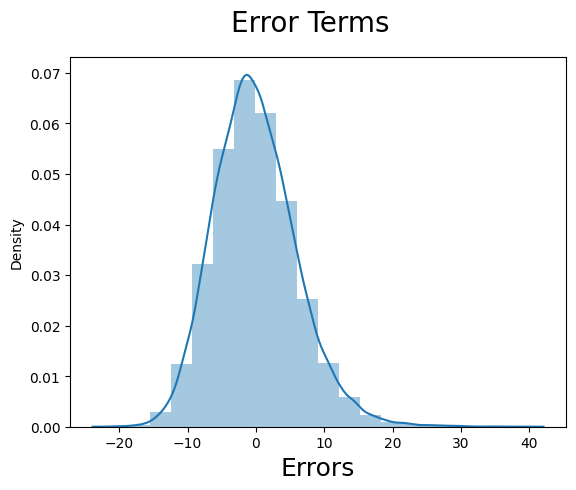

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

fig = plt.figure()
sns.distplot((y_test- y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
X_train_sm.drop(columns='const',axis=1,inplace=True)

In [ ]:
# Compare the scaled vs unscaled features used in the final model

scaled_coefficients = model2.params.drop('const')
print("Scaled Coefficients:")
print(scaled_coefficients)

# We need to re-create X_train and y_train from the original porter_df without scaling
X = porter_df[features].copy()
y = porter_df[target].copy()

# Apply the same outlier removal steps as before
for col in numerical_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X = X[(X[col] >= lower_bound) & (X[col] <= upper_bound)]

y = y.loc[X.index]

# Apply one-hot encoding to the original data
X = pd.get_dummies(X, columns=['market_id','order_protocol','order_day'], drop_first=True, dtype='int')

# Keep only the selected features
X_unscaled = X[selected_features]

missing_cols_unscaled = set(X_train_sm.columns) - set(X_unscaled.columns)
for c in missing_cols_unscaled:
    X_unscaled[c] = 0

# Ensure the order of columns is the same
X_unscaled = X_unscaled[X_train_sm.columns]


# Now calculate the unscaled coefficients
unscaled_coefficients = pd.Series(index=selected_features, dtype=float)
intercept = model2.params['const']

for feature in selected_features:
    if feature in numerical_cols:
        std_dev_feature = X_unscaled[feature].std()

        X_unscaled_sm = sm.add_constant(X_unscaled)
        unscaled_model = sm.OLS(y, X_unscaled_sm).fit()
        unscaled_coefficients = unscaled_model.params.drop('const')
        intercept = unscaled_model.params['const']
        break
    else:
         pass

if unscaled_coefficients.empty:
    # If numerical_cols was empty or the loop didn't break, fit the unscaled model
    X_unscaled_sm = sm.add_constant(X_unscaled)
    unscaled_model = sm.OLS(y, X_unscaled_sm).fit()
    unscaled_coefficients = unscaled_model.params.drop('const')
    intercept = unscaled_model.params['const']


print("\nUnscaled Coefficients:")
print(unscaled_coefficients)
print(f"\nUnscaled Intercept: {intercept}")

Scaled Coefficients:
total_outstanding_orders    4.122973
distance                    4.279354
market_id_2.0              -9.696137
market_id_3.0              -4.476325
market_id_4.0              -7.766265
market_id_5.0              -4.333626
market_id_6.0              -4.979548
order_protocol_5.0         -2.470657
dtype: float64

Unscaled Coefficients:
total_outstanding_orders    0.090336
distance                    0.492269
market_id_2.0              -9.653672
market_id_3.0              -4.459401
market_id_4.0              -7.719255
market_id_5.0              -4.304441
market_id_6.0              -5.057481
order_protocol_5.0         -2.453903
dtype: float64

Unscaled Intercept: 35.88405180244062


<Figure size 1400x700 with 0 Axes>

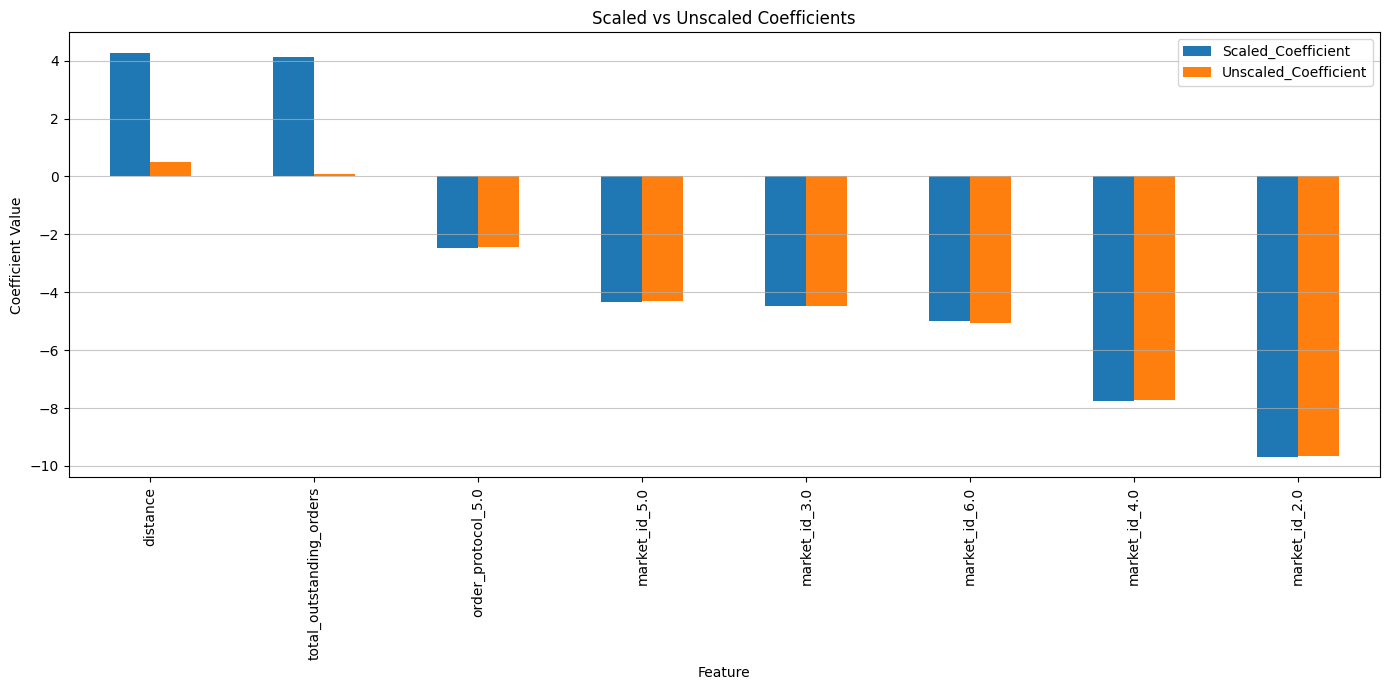

In [ ]:
coefficients_df = pd.DataFrame({
    'Feature': scaled_coefficients.index,
    'Scaled_Coefficient': scaled_coefficients.values,
    'Unscaled_Coefficient': unscaled_coefficients.values
})

# Plot scaled vs unscaled coefficients
plt.figure(figsize=(14, 7))
coefficients_df.sort_values(by='Scaled_Coefficient', ascending=False).plot(x='Feature', y=['Scaled_Coefficient', 'Unscaled_Coefficient'], kind='bar', figsize=(14, 7))
plt.title('Scaled vs Unscaled Coefficients')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'

print("\nImpact of a one-unit change in original (unscaled) features on delivery time:")
for feature in selected_features:
    if feature in unscaled_coefficients.index:
        impact = unscaled_coefficients[feature]
        print(f"  A one-unit increase in '{feature}' is associated with a change of {impact:.4f} minutes in delivery time.")
    else:
        print(f"  Coefficient for '{feature}' not found in unscaled coefficients.")

print("\nImpact of a one-standard-deviation change in scaled features on delivery time:")
for feature in selected_features:
    if feature in scaled_coefficients.index:
        impact = scaled_coefficients[feature]
        print(f"  A one-standard-deviation increase in scaled '{feature}' is associated with a change of {impact:.4f} minutes in delivery time.")
    else:
         print(f"  Coefficient for '{feature}' not found in scaled coefficients.")


Impact of a one-unit change in original (unscaled) features on delivery time:
  A one-unit increase in 'total_outstanding_orders' is associated with a change of 0.0903 minutes in delivery time.
  A one-unit increase in 'distance' is associated with a change of 0.4923 minutes in delivery time.
  A one-unit increase in 'market_id_2.0' is associated with a change of -9.6537 minutes in delivery time.
  A one-unit increase in 'market_id_3.0' is associated with a change of -4.4594 minutes in delivery time.
  A one-unit increase in 'market_id_4.0' is associated with a change of -7.7193 minutes in delivery time.
  A one-unit increase in 'market_id_5.0' is associated with a change of -4.3044 minutes in delivery time.
  A one-unit increase in 'market_id_6.0' is associated with a change of -5.0575 minutes in delivery time.
  A one-unit increase in 'order_protocol_5.0' is associated with a change of -2.4539 minutes in delivery time.

Impact of a one-standard-deviation change in scaled features on

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes we have categorical variables in the data such as 'market_id', 'store_primary_category', 'order_protocol', 'order_hour', 'order_day', 'isWeekend'.

> market_id - Different markets may have different traffic patterns, road distances and dasher availability. So markets in busy metro areas may show longer delivery times due to congestion, while others might be faster.

> store_primary_category - Food preparation time varies. Fast food likely has shorter delivery times, while dine-in or gourmet categories may have longer prep times, increasing time_taken_minutes.

> order_protocol - How the order is placed can affect response and processing time. Protocols involving manual confirmation or third parties might cause delays.

> order_hour - Time of day affects traffic, dasher availability, and restaurant readiness. Peak hours might show increased delivery times.

> order_day, isWeekend  - Day of week affects user behavior and dasher patterns. Weekends might show higher order volume or traffic congestion.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> This means that 20% of your dataset will be used as the test set, and the remaining 80% will be used for training your model.

So if we have 1,000 rows in your dataset:

- 800 rows go to X_train and y_train (used to train the model)
- 200 rows go to X_test and y_test (used to evaluate how well your model performs on unseen data)

This helps detect overfitting, when the model performs well on training data but poorly on new data.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> distance has the strongest positive correlation with time_taken_mins.It's correlation coefficient is 0.46.

- A correlation of 0.46 indicates a moderate positive relationship between distance and delivery time.
- The longer the distance, the more time it generally takes to deliver the order.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> To detect outliers, I used the Interquartile Range (IQR) method, a standard statistical technique.

For each numerical column, I calculated:

 - Q1 (25th percentile)

 - Q3 (75th percentile)

 - IQR = Q3 - Q1

Then I identified outliers as values that fall:

 - Below Q1 - 1.5 * IQR

 - Above Q3 + 1.5 * IQR

This approach helps in detecting unusually low or high values compared to the rest of the data.
I removed the detected outliers from both X_train and X_test using the IQR method.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> The top 3 features significantly affecting delivery time based on the final model are:

- Distance -> Coefficient: +4.28. As distance increases, delivery time increases.
- Total Outstanding Orders -> Coefficient: +4.12. More pending orders lead to longer delivery times, possibly due to delivery partner load.
- Market ID 2.0 -> Coefficient: -9.70. Being in Market significantly reduces delivery time compared to the reference market. This could indicate better logistics or lower traffic in that market.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear Regression is a supervised learning algorithm used for predicting a continuous output variable based on one or more input features

Types of Linear Regression
 - Simple Linear Regression <br>
    &nbsp; Explains the relationship between a dependent variable and one independent variable using a straight line <br>
    &nbsp; Y = β₀ + β₁X
    
 - Multiple Linear Regression <br>
    &nbsp; Explains the relationship between one dependent variable and several independent variables. <br>
    &nbsp; y = β₀ + β₁x₁ + β₂x₂ + ... + βpxₚ

Assumptions of Linear Regression:
- Linearity: Relationship between X and y is linear.
- Independence: Observations are independent.
- Homoscedasticity: Constant variance of errors.
- Normality: Errors are normally distributed.

Model Evaluation Metrics:
- R² Score - Coefficient of Determination.
- MAE (Mean Absolute Error): Average of absolute errors.
- MSE (Mean Squared Error): Average of squared errors.
- RMSE (Root Mean Squared Error): Square root of MSE.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**

- Simple Linear Regression <br>
    - Explains the relationship between a dependent variable and one independent variable using a straight line. <br>
    - Y = β₀ + β₁X <br>
    - Easy to visualize and interpret <br>
    - Ex: Predicting delivery time based on only the distance
    
- Multiple Linear Regression <br>
    - Explains the relationship between one dependent variable and several independent variables. <br>
    - y = β₀ + β₁x₁ + β₂x₂ + ... + βpxₚ <br>
    - More complex, but more flexible <br>
    - Ex: Predicting delivery time based on distance, order count, and market id



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function (also called the loss function) quantifies how well the model's predictions match the actual values. In linear regression, the most common cost function is Mean Squared Error (MSE).It's typically minimized using gradient descent, an iterative optimization algorithm.

We use a technique called Gradient Descent (or other optimization algorithms) to minimize the cost function.
The algorithm updates the model’s coefficients iteratively to minimize the MSE by calculating the gradient (slope) of the cost function.





---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting: Occurs when the model is too complex and fits the training data too well — even capturing the noise. The model performs well on training data but poorly on unseen test data.

> It is caused because the model has too many features or it is too complex.

> Fix:<br>
- Simplify the model
- Use regularization
- Collect more data

> Underfitting: Occurs when the model is too simple to capture the underlying trend in the data. The model has high bias, making poor predictions on both training and test data.

> It is cause if there are too few features or too simple model.

> Fix: <br>
- Use a more complex model
- Add more features




---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> A residual is the difference between the actual value and the predicted value.

> Residual plots help you check if your linear regression assumptions hold. They reveal issues like non-linearity, heteroscedasticity, and outliers. Always inspect residuals to validate the model before making conclusions.

> Types of residual plots:
- Residuals vs. Predicted Values
- Histogram of Residuals
- Quantile-Quantile Plot

> We can diagnose the model based on observation of plot:
- Residuals are randomly scattered around zero - Model is appropriate(Good fit)
- Residuals show a pattern (curve, wave) - Model is underfitting
- Clusters or groups - We need to add more features